In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [8]:
df_credit = pd.read_csv("Datasets/CreditRisk/german_credit_data.csv", index_col=0)
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [9]:
pdp.ProfileReport(df_credit)

Number of variables,10
Number of observations,1000
Total Missing (%),5.8%
Total size in memory,85.9 KiB
Average record size in memory,88.0 B
Numeric,4
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


With the analysis of the variables. The correlations show that between two variables there is not a high correlation with the exception of the credit duration and the credit amount. Which is positive and means that the higher the amount of the credit the higher the duration of it. This makes sense, since people will obviously take longer to pay back a higher amount of money.

### Missing values and NANs

In [10]:
df_credit.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [11]:
df_credit.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

They are one and the same the NANs and the null values. That means there are no empty values in the dataframe.

In [12]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


#### Non numerical columns

In [13]:
cat_cols = [col for col in df_credit.columns if df_credit[col].dtypes == 'O']
for col in cat_cols:
    print(df_credit[col].value_counts(), "\n\n")

male      690
female    310
Name: Sex, dtype: int64 


own     713
rent    179
free    108
Name: Housing, dtype: int64 


little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64 


little      274
moderate    269
rich         63
Name: Checking account, dtype: int64 


car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64 


good    700
bad     300
Name: Risk, dtype: int64 




### Target variable

In [15]:
unique_target, counts_target = np.unique(df_credit.Risk, return_counts=True)

<BarContainer object of 2 artists>

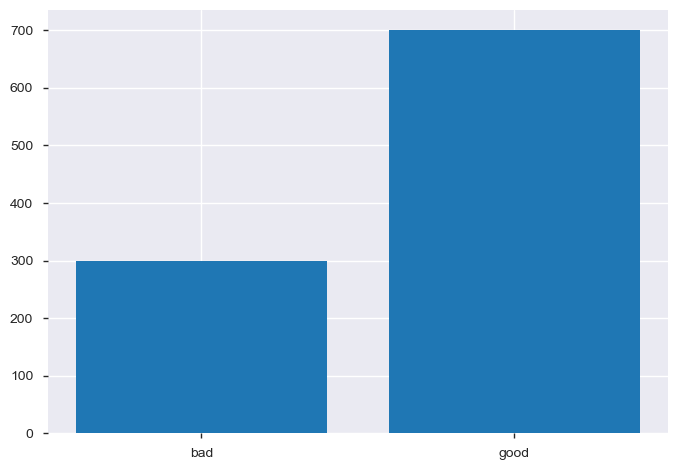

In [24]:
plt.bar(unique_target, counts_target)

### Numerical analysis
Every numerical column displayed based on the target variable. That waz we can perceive key variables.

Number of numerical Variable:  4


C:\Users\migue\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


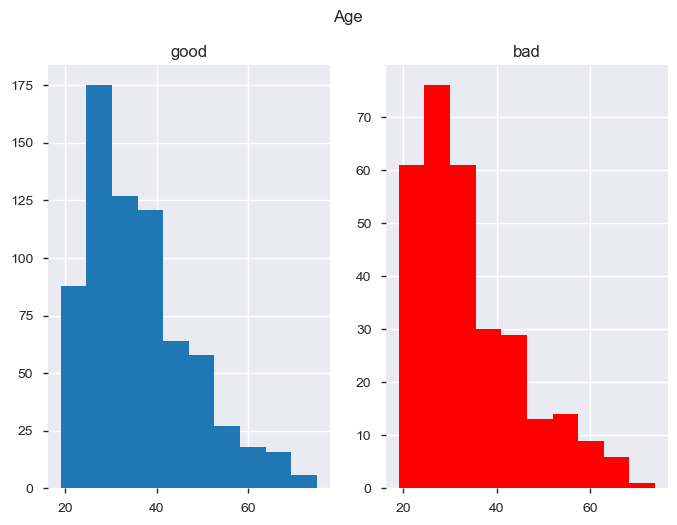

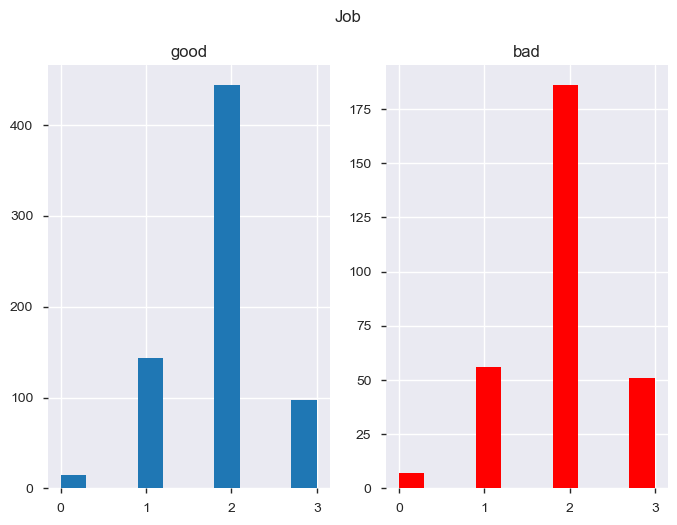

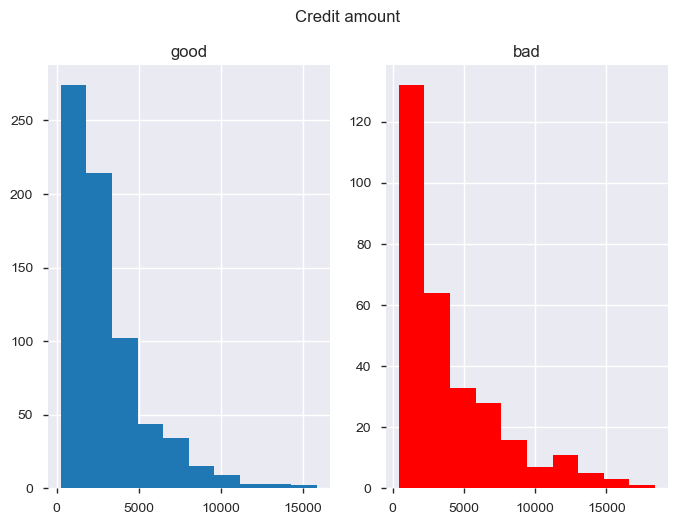

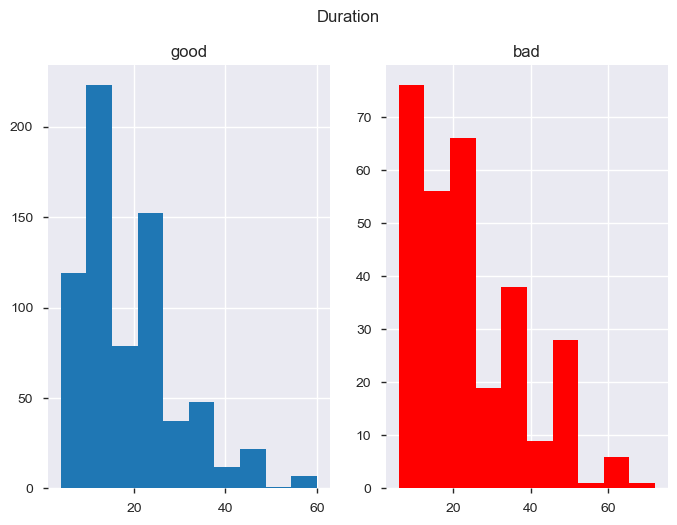

In [36]:
num_cols = [col for col in df_credit.columns if df_credit[col].dtypes != 'O' and col not in 'Id']
print('Number of numerical Variable: ', len(num_cols))
for col in num_cols:
    temp_good = df_credit[df_credit.Risk=='good'][col]
    temp_bad = df_credit[df_credit.Risk=='bad'][col]
    fig, (ax_g, ax_b) = plt.subplots(1,2)
    
    ax_g.hist(temp_good)
    ax_g.set_title('good')
    
    ax_b.hist(temp_bad, color='red')
    ax_b.set_title('bad')
    
    fig.suptitle(col)
    fig.show()

As expected in this type of task, the dataset is nunbalanced in its classes. The bank has more info on the good clients than on th bad ones. We might have to use a custom loss or to do data augmentation to make our model understand better the bad labels.
## Normalization
The column of credit amount does not have a normal distribution. Also the minimum and maximum values are really far from each other, therefore it would be better to use a log function.

(array([  7.,  16.,  69., 175., 198., 194., 155., 109.,  55.,  22.]),
 array([5.52146092, 5.95145577, 6.38145062, 6.81144547, 7.24144033,
        7.67143518, 8.10143003, 8.53142488, 8.96141974, 9.39141459,
        9.82140944]),
 <a list of 10 Patch objects>)

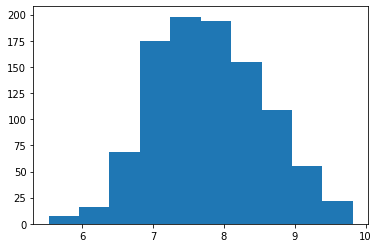

In [4]:
plt.hist(np.log(df_credit['Credit amount']))

## One hot endcoding
For the column job I will do two experiments. The first one is leaving the values the way they are. Giving qualified workers a higher value than non qualified ones. The second one will be removing the measure of job and using one hot encoding for the type of workers.

In [22]:
df_credit.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [28]:
df_credit["Purpose"].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

## Building input and label data
### Simplest models.
These models will use only numerical data to calculate the risk

In [5]:
y = df_credit.Risk.values
X = df_credit[["Age", "Job", "Credit amount","Duration"]].values

In [6]:
y = np.where(y == "good", 1, y)
y = np.where(y=="bad",0,y)
y=y.astype('int')

In [7]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.2)
X_trn, X_val, y_trn, y_val = train_test_split(X_trn, y_trn, test_size = 0.2)

In [8]:
print(X_trn.shape, X_val.shape, X_tst.shape, y_trn.shape, y_val.shape, y_tst.shape)

(640, 4) (160, 4) (200, 4) (640,) (160,) (200,)


#### Logistic regression

In [9]:
clf = LogisticRegression(random_state=0).fit(X_trn[:40], y[:40])
y_hat = clf.predict(X_tst)

C:\Users\migue\Anaconda3\envs\TensorFlow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
rmse = (((y_tst-y_hat)**2).mean())**0.5
print(rmse)

0.570087712549569


In [11]:
clf.score(X_tst, y_tst) # RMSE

0.675

#### Decition Tree

In [12]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_trn, y_trn)
y_hat = clf.predict(X_tst)
rmse = (((y_tst-y_hat)**2).mean())**0.5
clf.score(X_tst, y_tst)

0.655

In [13]:
rmse

0.5873670062235365

It improved the results from the logistic regression. However I think it can be greatly improved.
#### Random forest

In [14]:
clf = RandomForestClassifier(max_depth = 10, random_state=0, n_estimators=500)
clf.fit(X_trn, y_trn)
y_hat = clf.predict(X_tst)
rmse = (((y_tst-y_hat)**2).mean())**0.5
print(clf.score(X_tst, y_tst), rmse)

0.705 0.5431390245600107


It improves the decition tree but it is stuck at 0.66 score, regardless of the depth of the forest and the number of trees

#### Neural network

In [47]:
input_layer = tf.keras.layers.Input(X_trn.shape[1:])
dense = tf.keras.layers.Dense(128, activation='relu')(input_layer)
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
opt = tf.keras.optimizers.Adagrad(lr = 1e-4)
model.compile(optimizer=opt, loss=tf.keras.losses.MAE,
             metrics=[tf.keras.metrics.binary_accuracy])
callback_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0)
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='loss', verbose=0,
                                                         save_weights_only=True, save_best_only=True)
callbacks = [callback_early, callback_checkpoint]
history = model.fit(x=X_trn, y = y_trn, callbacks=callbacks, validation_data=[X_val, y_val], batch_size=128, epochs=30, verbose=0)

In [48]:
y_hat = model.predict(X_tst)
rmse = (((y_tst-y_hat)**2).mean())**0.5

In [49]:
print(rmse)

0.570087710001081


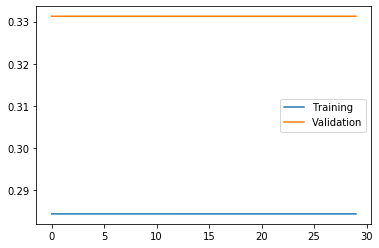

In [50]:
plt.plot(history.history["loss"], label='Training')
plt.plot(history.history["val_loss"], label='Validation')
plt.legend()